# Predicting Type of Crime Incident in Oakland
The city of Oakland is notorious for being rife with gun violence and drug abuse, among other crimes, and although the 21st century has seen crime rates drop substantially, there are still an endless number of crimes being committed daily. Is there a way we might be able to distinguish more severe incidents from less?

The goal of this project is to develop a model for predicting the kind of crime being committed in Oakland, California from 2013-2014 crime statistic data. 

First, I will import some essential packages and read in the data as a pandas dataframe. 

In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline
pd.options.mode.chained_assignment = None

In [236]:
crime = pd.read_csv('data/prr-10437.csv')
crime.head()

,EVENT NUMBER,DATE/TIME,ADDRESS ROUNDED TO BLOCK NUMBER OR INTERSECTION,PATROL BEAT,INCIDENT TYPE,INCIDENT TYPE DESCRIPTION,PRIORITY
0,LOP130101000001,2013-01-01T00:00:00.000,2700 78TH AV,30Y,415SS,415 SHOT SPOTTER GUN,2
1,LOP130101000002,2013-01-01T00:00:00.000,8700 D ST,33X,415GS,415 GUNSHOTS,1
2,LOP130101000003,2013-01-01T00:00:00.000,1800 BRIDGE AV,23X,243E,BATTERY ON CO-HABITA,1
3,LOP130101000004,2013-01-01T00:00:00.000,7600 ARTHUR ST,30X,415GS,415 GUNSHOTS,2
4,LOP130101000005,2013-01-01T00:02:00.000,55TH AV & BROOKDALE AV,29X,415GS,415 GUNSHOTS,2


Looking at the data, there are a few categorical variables we could glean from it: incident type, location, time, patrol beat and priority. Unfortunately, there are no numerical continous variables to work with.

I'll start by changing the column labels to ones that are easier to work with, and dropping columns I do not need.

In [237]:
crime.columns = ['event_number', 'date', 'address', 'patrol_beat', 'incident_type', 'incident_desc', 'priority']
crime = crime.drop(['event_number', 'incident_type', 'patrol_beat'], axis=1)

# Data Cleaning and Visualization

### Classes for Type of Incident
The 'incident_desc' column provides a truncated description of the crime that occurred. Most of the descriptions are human-readable and easily understood, while others have been shortened too much to tell what they are or unknown to civilians. 

In [238]:
incident_counts = crime.incident_desc.value_counts().sort_values(ascending=False)
top_incident_counts = incident_counts[incident_counts > 100]
top_incident_counts.shape

(224,)

Here, I have extracted incidents that have occurred more than 100 times in the dataset. There are 224 different categories of crime that have more than 100 occurrences; the other categories only make up about 4,000 separate incidents in a dataset with over 750,000 entries, so for simplicity's sake I will exclude the other categories.

In [239]:
print(top_incident_counts.sum())
print(incident_counts.sum())

755074
758815


My reason for doing this is I will be manually classifying these 224 categories into "serious" incidents and "petty" incidents. I define a serious incident as severe crimes that involves one of the following: inflicting harm or threats of inflicting harm on another person, the taking or damaging of another person's property, damaging property, or activities involving vices such as sex, drugs alcohol, and gambling. Petty incidents are any other less severe crimes that do not fit the description of serious incidents, such as alarms ringing and minor disturbances. The classes are defined below; you can see the incident descriptions that fall under these classes yourself. There is also another class that I will not be using, as they are incidents that fall into one of these categories: incidents relating to animal control, parking violations, or police operations. 

In [240]:
serious_incidents = ['DISTURBING THE PEACE', 'BATTERY', 'BATTERY ON CO-HABITA', 'ROBBERY', '415 GUNSHOTS', 
                '415 SHOT SPOTTER GUN', '415 THREATS', 'HAZARDOUS SITUATION/', 'HIT & RUN (PROPERTY', 'TRESPASS:', 
                'VEHICLE COLLISION-PE', 'ASSAULT W/DEADLY WEA', 'SPECIAL ENFORCEMENT', 'FIGHT', 'RECKLESS DRIVING', 
                'SUBJECT ARMED WITH W', 'CRUELTY TO ANIMAL', 'PERSON SCREAMING',  'BRANDISH A WEAPON', 
                'INSANE PERSON-VIOLEN', 'DISORDERLY CONDUCT', 'SHOOTING AT/INTO AN', 'HIT & RUN RESULTING', 
                'SEXUAL ASSAULT; RAPE', 'CHILD ENDANGERMENT O', 'PROWLER OUTSIDE', 'INFLICT INJURY ON CH', 
                'DISORDERLY CONDUCT:', 'CRIMES AGAINST CHILD',  'VEHICLE COLLISION-HI', 'VEHICLE COLLISION-CI', 
                "OBSTRUCT PERSON'S MO", 'CRUELTY TO DEPENDENT', 'ASSAULT', 'ARSON', 'THREATEN CRIME WITH', 
                'ROBBERY: FIRST DEGRE', 'ATTEMPTED ROBBERY', 'VEHICLE COLLISION-DR', 'STALKING', 'KIDNAPPING', 
                'ASSAULT WITH CAUSTIC', 'FORCED ENTRY IN PROG', 'WILLFUL CRUELTY TO C', 'CHILD STEALING', 'FOUND GUN', 
                'INFLICT INJURY ON SP', 'SEXUAL BATTERY', 'FALSE IMPRISONMENT', 'DRUG DEALING', 'DISTURBANCE-DRINKERS', 
                'VANDALISM', 'DRUNK ON THE STREET', 'PROSTITUTION/DISORDE', 'USE OF/UNDER INFLUEN', 'INDECENT EXPOSURE', 
                'OVERDOSE', 'POSSESS NARCOTIC CON', 'GAMBLING', 'DRUNK INSIDE BUILDIN', 'DRUNK IN AUTO',  
                'DUI ALCOHOL/DRUGS', 'STOLEN VEHICLE', 'BURGLARY', 'AUTO BURGLARY--IP', 'GRAND THEFT', 'ATTEMPTED BURGLARY', 
                'CARJACKING', 'ATTEMPTED AUTO THEFT', 'THEFT', 'THEFT COIN OPERATED', 'ATTEMPT SUICIDE', 'SUICIDE THREATS', 
                'POSSIBLE DEAD PERSON',]

petty_incidents = ['ALARM-RINGER', 'CAR STOP', 'SUSPICIOUS PERSON', 'LOUD MUSIC', 'RECOVERED STOLEN VEH', '415 FAMILY', 
                   'WALKING STOP', 'SUSPICIOUS VEHICLE',  'DISTURBANCE-NEIGHBOR', 'AMBULANCE REQUESTED', '415 UNKNOWN', 
                   'VEHICLE COLLISION/PR',  'ALARM-MANUALLY ACTIV', 'RUNAWAY', 'STOLEN LICENSE PLATE', 'EMBEZZLEMENT',
                   'VIOLATION OF COURT O', 'DISTURBANCE-CUSTOMER', '415 BOYFRIEND', 'SILENT ROBBERY ALARM', 
                   'DISTURBANCE-UNWANTED', 'MISSING PERSON', 'VEHICLE COLLISION-UN', 'DISTURBANCE-LANDLORD', 
                   '415 FIRE CRACKERS', 'DISTURBANCE-AUTO', 'SUSPECT', 'STOP ON A BICYCLE', 'SLEEPER', 
                   'DISTURBANCE-JUVENILE', 'ALARM-SILENT', 'MISSING JUVENILE', 'MISSING PERSON AT RI',  'LOJACK HIT', 
                   'CHRONIC CALLER', 'DUMP WASTE OR OFFENS', 'AUTO ALARM', 'LEASH LAW VIOLATION',  'ALARM-SCHOOL ALARM', 
                   'CONTEMPT OF COURT OR', 'PICKETERS/PROTESTERS',  'AUTO ON FIRE', 'IDENTITY THEFT', 'SENILE PERSON', 
                   'SMOKE', 'ABSENT WITHOUT LEAVE', 'DEFRAUDING AN INNKEE', 'DEPRIVE CUSTODY RIGH',  'EXPLOSION', 
                   'ALARM-TRACKER',  'GAS LEAK', 'RECEIVE KNOWN STOLEN',  'BAD SMELL', 'TRUANT', 
                   'VIOLATION OF CUSTODY', 'COUNTERFEIT CURRENCY', 'FORGERY', 'CAR PROWLER OR CLOUT',]

not_included = ['ON VIEW', 'BEAT INFORMATION','COMM ORDER', 'SECURITY CHECK', '911 HANG-UP', 'MENTALLY ILL', 
                 'ABANDONED AUTOMOBILE', 'BROADCAST', 'PERSONAL BREAK', 'AUTO BLOCKING DRIVEW', 'WELFARE CHECK -- CHE', 
                 'MEAL BREAK', 'REPORT REVIEW', 'TEC CALL', 'CHECK VEHICLE', 'STAND BY AND PRESERV', 'ANIMAL-STRAYING', 
                 'EVALUATION','FOUND PROPERTY', 'OAKLAND MUNICIPLE CO', 'INJURIED ANIMAL', 'VICIOUS ANIMAL', 
                 'AFTER HOURS IA REFER', 'PHONE RPT','ASSIST', 'POLICE RELATED MATTE', 'MAKE A PHONE CALL', 'SIDESHOW', 
                 'MISDIAL', 'TOW REQUESTED', 'PERSON DETAINED-IN C', 'INVESTIGATE REPORT O', 'FIRE',
                 'ASSOCIATED TYPE FROM',  'MEET THE OFFICER', 'DEAD ANIMAL PICK UP', 'HOMELESS ENCAMPMENT', 
                 'MISCELLANEOUS/UNKNOW', 'POUND', 'INCORRIGIBLE: BEYOND', 'AMBULANCE FOLLOW UP',
                 'EMERGENCY TRAFFIC ON', 'ASSIST OUTSIDE AGENC', 'COVER THE OFFICER', 'GIRLFRIEND CREATING', 
                 'UNSECURED PREMISE', 'WALKING BEAT', 'EVIDENCE', 'STREET CLOSURE', 'TRAINING', 'VIDEO EVIDENCE', 
                 'WAGON REQUESTED', 'DISTURBING BETWEEN R', 'COMMUNITY MEETING', 'RADIO SOUND TEST',
                 'LIVE ANIMAL PICK UP', 'ANIMAL BITE', 'TEST', 'PICK UP', 'AUTO IN RESTRICED ZO', 'BARKING DOG', 
                 'UNITS ON SURVEILLANC', 'AUTO IMPROPERLY PARK', 'VEH PARKED IN SIGNED', 'WARRANT SERVICE', 'WASHDOWN', 
                 'SIGNALS-MALFUNCTIONI', 'VEHICLE PARKED ON SI', 'STALLED VEH', 'WALK THROUGH', 'NON POLICE/LAW RELAT', 
                 'TRAFFIC CONTROL POST', 'TRANSPORTING ADMINIS', 'PURSUIT', 'ON-LINE REPORT (COPL', 'VICTIM', 'SEARCH', 
                 '21235 MOTORSCOOTER', 'PRIVATE EYE', 'WIRES', 'COFFEE BREAK', 'FOUND JUVENILE', 'PICK UP 261 KIT', 'WATER', 
                 'ELECTRONIC DEVICE', 'FOUND SENILE', 'OFF DUTY (PCD)', 'INVESTIGATE REPORT F', 'GUARD', 'LOST PROPERY', 
                 'SUPPLEMENT', 'MOBILE FIELD FORCE', ]

In [241]:
print('Number of serious incidents:', top_incident_counts[serious_incidents].sum())

Number of serious incidents: 198082


In [242]:
print('Number of petty incidents:', top_incident_counts[petty_incidents].sum())

Number of petty incidents: 199137


Although we've lost a little less than half of the observations, the data still has around 400,000 rows that I can work with. Furthermore, the classes are very well balanced, which is generally desired in classification problems. 

Below, I have created a new column for the class of the incident using a simple user-defined function and I have dropped the 'incident_desc' column since it is no longer needed. 

In [243]:
def incident_type(incident):
    if incident in serious_incidents:
        return 'serious'
    elif incident in petty_incidents:
        return 'petty'
    else:
        return 'other'
    
crime['incident_type'] = crime.incident_desc.apply(incident_type)
crime = crime[crime.incident_type != 'other']
crime = crime.drop('incident_desc', axis=1)
crime.sample(5)

,date,address,priority,incident_type
308639,2013-10-30T09:34:00.000,6200 COLISEUM WY,1,serious
734325,2014-12-08T06:12:00.000,2500 SAN PABLO AV,3,petty
213000,2013-07-30T20:27:00.000,2100 94TH AV,2,petty
214689,2013-08-01T13:27:00.000,1600 6TH AV,2,petty
311648,2013-11-01T22:07:00.000,CHAMPION ST & EB I580,2,petty


### Geographical Data
The data only contains the street address at which the incident occurred. I would like to start by first converting the addresses into coordinate points, and then later clustering coordinates to assign each incident a geographical group.

Using Texas A&M University's online geocoding service through their Partner Program (for more information, visit their site [here](https://geoservices.tamu.edu)), I will convert the street addresses in the data to latitude and longitude points. 

The code below finds all the unique addresses in the data and creates a dataframe of a form that is compatible with Texas A&M's geocoder. Because the geocoder can only convert 2,500 addresses at a time, I exported eight sets with at most 2,500 rows each to .csv files.

In [244]:
unique_addresses = pd.DataFrame(crime.address.value_counts().index, columns=['Address'])
unique_addresses['City'] = 'Oakland'
unique_addresses['State'] = 'CA'
unique_addresses['Zip'] = ''

for i in range(8):
    set = unique_addresses.iloc[2500*i:2500*(i+1), :]
    file_name = 'data/unique_address_sets/address_set_' + str((i+1)) + '.csv'
    set.to_csv(file_name, index=False)

After the unique addresses have been geocoded, I imported all the sets and combined them into a single dataframe containing the street address, latitude, and longitude. Observing the descriptive statistics of this dataframe, there seems to be an error for at least one of the addresses, since the minimum latitude is 1 and the maximum longitude is about 37.

In [245]:
list_geocoded_sets = []
for i in range(8):
    geocoded_file_name = 'data/unique_address_geocoded/address_set_' + str((i+1)) + '.csv'
    geocoded_set = pd.read_csv(geocoded_file_name, usecols=['Address', 'Latitude', 'Longitude'])
    list_geocoded_sets.append(geocoded_set)
geocoded_df = pd.concat(list_geocoded_sets).dropna().reset_index(drop=True)
geocoded_df.describe()

,Latitude,Longitude
count,18628.000000,18628.000000
mean,37.744754,-122.057309
std,1.174478,5.107630
min,1.000000,-122.356121
25%,37.771089,-122.224977
50%,37.771089,-122.224977
75%,37.795650,-122.206914
max,37.998727,37.837924


I tried subsetting the dataframe by latitude values greater than one, which seems to have fixed the problem but dropped 19 of the addresses. I am assuming that these addresses were incorrectly geocoded, or that the original data contained faulty addresses that the geocoder could not parse. 

In [246]:
geocoded_df = geocoded_df[geocoded_df.Latitude > 1]
geocoded_df.describe()

,Latitude,Longitude
count,18609.000000,18609.000000
mean,37.782271,-122.220508
std,0.027914,0.030910
min,36.970650,-122.356121
25%,37.771089,-122.224977
50%,37.771089,-122.224977
75%,37.795681,-122.207054
max,37.998727,-121.966168


Moving on, I inner-joined the crime data with the unique addresses to produce a dataframe with latitude and longitude data for all of the incidents with valid addresses.

In [247]:
crime = crime.merge(geocoded_df, left_on='address', right_on='Address', how='inner')
crime = crime.drop(['Address', 'address'], axis=1)
crime.sample(5)

,date,priority,incident_type,Latitude,Longitude
371752,2014-04-15T20:44:00.000,2,serious,37.765407,-122.170336
287367,2014-05-04T19:02:00.000,2,serious,37.771089,-122.224977
193159,2013-12-03T23:18:00.000,2,petty,37.804315,-122.271196
333776,2013-08-14T04:24:00.000,3,petty,37.846692,-122.265428
239496,2013-02-02T19:08:00.000,2,petty,37.839599,-122.242365


Now, I wanted to plot the coordinates on a map to visualize how the incidents were distributed geographically. Using the Basemap package from matplotlib, I created a rudimentary map of the points plotted in the vicinity of the Oakland area. I did this to see if there were any problematic points or sets of points in the data. 

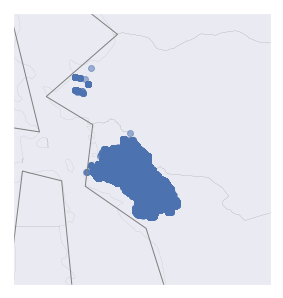

In [248]:
from mpl_toolkits.basemap import Basemap

crime_lon = crime.Longitude.values
crime_lat = crime.Latitude.values

fig = plt.figure(figsize=(5, 5))
m = Basemap(projection='merc', resolution='l', 
            urcrnrlon=-121.9, urcrnrlat=38.1,
           llcrnrlon=-122.5, llcrnrlat=37.6)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawcounties(color='grey')
m.scatter(crime_lon, crime_lat, latlon=True, alpha=0.5)
plt.show()

Looking at the map, there definitely seems to be a cluster of points that don't align with the rest of the data. I examined an actual map of the Bay Area and found that these points are actually in Richmond, a city north of Oakland. Because these points are not pertinent to the area of interest, I removed them by filtering the data for incidents that occured below a latitude that definitely contained all of the Oakland points, but none of the Richmond points.

In [249]:
print('Number of observations before removing outliers:', crime.shape[0])
crime = crime[crime.Latitude < 37.915]
print('Number of observations after removing outliers:', crime.shape[0])

Number of observations before removing outliers: 397141
Number of observations after removing outliers: 396720


Only about 400 points were lost by removing the Richmond data.

With all of the points now located in Oakland, I plotted a more detailed map of the incident coordinates.

http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=-122.348504,37.705000000000005,-122.10916400000002,37.88234&bboxSR=4326&imageSR=4326&size=1500,1111&dpi=96&format=png32&transparent=true&f=image


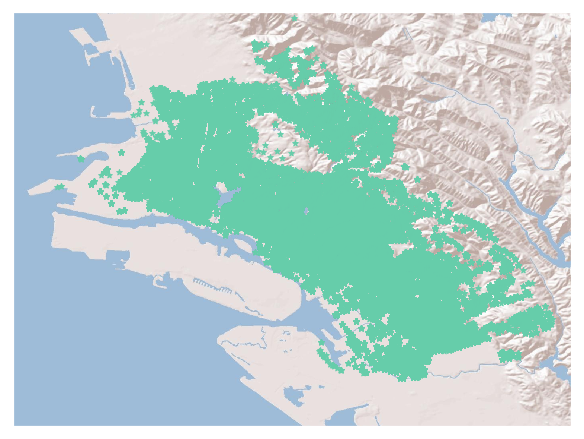

In [250]:
crime_lon = crime.Longitude.values
crime_lat = crime.Latitude.values

fig = plt.figure(figsize=(10, 10))
m = Basemap(projection='merc', resolution='l', 
            urcrnrlon=-122.109164, urcrnrlat=37.88234,
           llcrnrlon=-122.348504, llcrnrlat=37.705, epsg=4326)
m.arcgisimage(service='World_Shaded_Relief', xpixels = 1500, verbose= True)
m.scatter(crime_lon, crime_lat, latlon=True, marker='*', color='mediumaquamarine')
plt.show()

The data is very dense all over Oakland and there do not seem to be any obvious ways to cluster the points. For this reason, I chose to use the districts determined by the city of Oakland to cluster these points. Using a Shapefile of Oakland districts (found [here](http://data.openoakland.org/dataset/oakland-city-council-districts-shape-files-shp)), I converted the district lines to Coordinate Reference System WGS84 (which is the CRS used for plotting this Basemap) using the QGIS desktop application. I also extracted the centroids of districts in QGIS. I overlaid both the district lines and centroids on the map. I have also plotted the points by incident type to get a better idea of the density distribution of the two categories.

http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=-122.348504,37.705000000000005,-122.10916400000002,37.88234&bboxSR=4326&imageSR=4326&size=1500,1111&dpi=96&format=png32&transparent=true&f=image


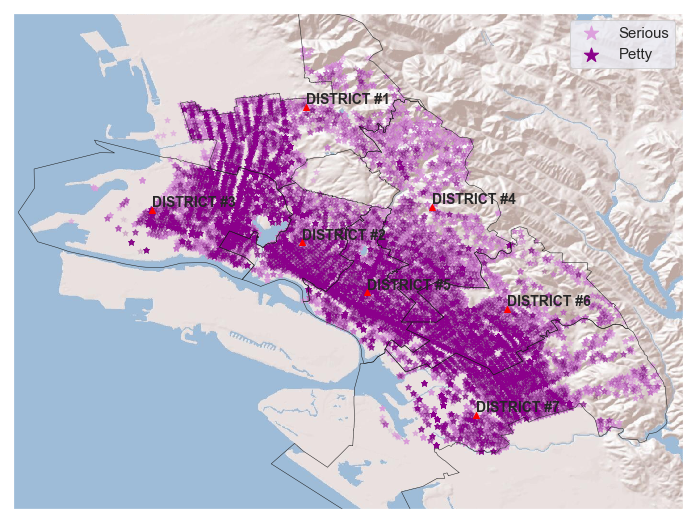

In [251]:
binary_incident_type = crime.incident_type.astype('category').cat.codes
lon_s = crime[crime.incident_type == 'serious'].Longitude.values
lat_s = crime[crime.incident_type == 'serious'].Latitude.values
lon_p = crime[crime.incident_type == 'petty'].Longitude.values
lat_p = crime[crime.incident_type == 'petty'].Latitude.values

fig = plt.figure(figsize=(12, 12))
m = Basemap(projection='merc', resolution='l', 
            urcrnrlon=-122.109164, urcrnrlat=37.88234,
           llcrnrlon=-122.348504, llcrnrlat=37.705, epsg=4326)
m.arcgisimage(service='World_Shaded_Relief', xpixels = 1500, verbose= True)
m.scatter(lon_s, lat_s, latlon=True,  
        c='plum', marker='*', alpha=0.5, label='Serious')
m.scatter(lon_p, lat_p, latlon=True,  
        c='darkmagenta', marker='*', alpha=0.01, label='Petty')
plt.legend(prop={'size': 15}, markerscale=2.5)
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_alpha(1)
leg.legendHandles[1].set_alpha(1)

m.readshapefile('data/OaklandSHP/OaklandCCD', 'oakland_districts')
district_centroids = pd.read_csv('data/OaklandSHP/District_Centroids.csv', usecols=['DIST_NAME', 'Latitude', 'Longitude'])
centroid_lat = district_centroids.Latitude.values
centroid_lon = district_centroids.Longitude.values
districts = district_centroids.DIST_NAME.values

for lon, lat, name in zip(centroid_lon, centroid_lat, districts):
    plt.text(lon, lat, name, fontsize=14, fontweight='bold', ha='left', va='bottom')
    m.scatter(lon, lat, latlon=True, marker='^', color='red')

plt.show()

The district lines line up very well with the boundaries of the plotted points. There are seven districts in Oakland, so I will create seven clusters that each point will be categorized as. Because I am unable to determine which points fall into the Shapefile lines through Basemap, I decided to use k-Means Clustering with the initial centers set at the centroids of the districts in order to classify which district each point fell into. 

In [252]:
from sklearn.cluster import KMeans

centroids = np.array(list(zip(centroid_lon, centroid_lat)))
coordinates = np.array(list(zip(crime_lon, crime_lat)))
km = KMeans(n_clusters=7, init=centroids, n_init=1, random_state=42).fit(coordinates)
crime['district'] = km.labels_ + 1
crime = crime.drop(['Latitude', 'Longitude'], axis=1)
crime.sample(5)

,date,priority,incident_type,district
288666,2014-05-27T15:22:00.000,2,petty,3
369735,2014-06-02T05:45:00.000,1,serious,7
359239,2014-01-11T11:49:00.000,2,serious,5
338429,2014-12-22T21:53:00.000,1,serious,5
264625,2013-01-22T23:10:00.000,2,serious,2


I dropped the 'Latitude' and 'Longitude' columns of the data since I no longer need them. After clustering with k-Means, I plotted the data again and colored each point by their district. I also plotted the new centers of the district calculated by k-Means. 

http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=-122.348504,37.705000000000005,-122.10916400000002,37.88234&bboxSR=4326&imageSR=4326&size=1500,1111&dpi=96&format=png32&transparent=true&f=image


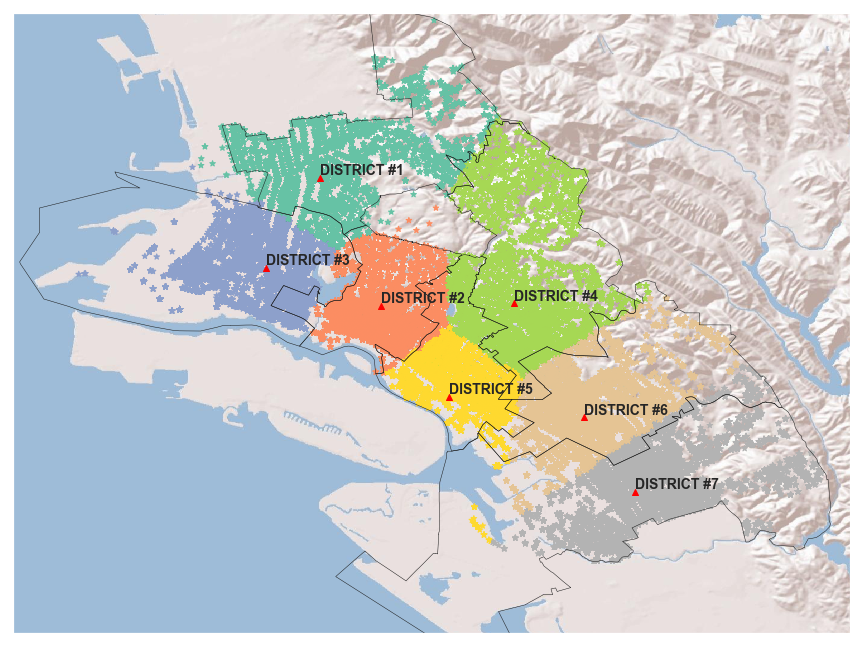

In [253]:
fig = plt.figure(figsize=(15, 15))
m = Basemap(projection='merc', resolution='l', 
            urcrnrlon=-122.109164, urcrnrlat=37.88234,
           llcrnrlon=-122.348504, llcrnrlat=37.705, epsg=4326)
m.arcgisimage(service='World_Shaded_Relief', xpixels = 1500, verbose= True)
m.scatter(crime_lon, crime_lat, latlon=True, 
          c=crime.district.values, cmap='Set2', marker='*')
m.readshapefile('data/OaklandSHP/OaklandCCD', 'oakland_districts') 

clusters_labels = list(zip(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], districts))
for lon, lat, name in clusters_labels:
    plt.text(lon, lat, name, fontsize=14, fontweight='bold', ha='left', va='bottom')
    m.scatter(lon, lat, latlon=True, marker='^', color='red')

plt.show()

Although the points are not perfectly clustered into the actual districts, most of the clusters are fairly close. The biggest issue I see is the overlapping area between districts 2, 4, and 5, where a lot of 5's area is taken up by 2 and 4. Regardless, this will suffice for what I am doing. 


Now that each incident is clustered into a district, I would like to observe how many serious and petty incidents occurred in each district. I defined a function that would do this, as I think it will be helpful with other features as well. 

In [254]:
def incident_count_table(col_name):
    serious_counts = crime[crime.incident_type=='serious'].groupby(crime[col_name])['incident_type'].count()
    petty_counts = crime[crime.incident_type=='petty'].groupby(crime[col_name])['incident_type'].count()
    incident_counts = pd.concat([serious_counts, petty_counts], axis=1).reset_index()
    incident_counts.columns = [col_name, 'serious', 'petty']
    return incident_counts

incident_counts_by_district = incident_count_table('district')
incident_counts_by_district

,district,serious,petty
0,1,14509,20424
1,2,17056,18790
2,3,24316,26900
3,4,13598,19263
4,5,78899,64526
5,6,24973,25223
6,7,24440,23803


A huge portion of both serious and petty crimes occurred in district 5, meaning the density of incidents in that area was much higher than the rest of the districts; especially considering how small of an area it takes up. 

### Temporal Data
The dataset includes a 'date' column, which includes day, month, year, and time information. First, I would like to see the trends of the counts of serious and petty incidents. I converted the 'date' column to datetime and grouped the data into each individual day contained in the data, which I then aggregated by incident type count. 

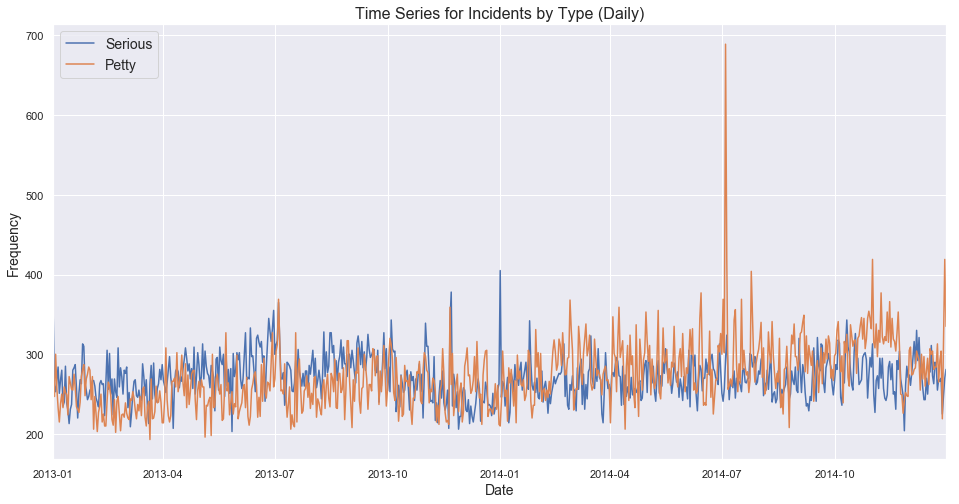

In [255]:
crime['date'] = pd.to_datetime(crime.date)

serious_counts_by_date = crime[crime.incident_type=='serious'].groupby(crime['date'].dt.date)['incident_type'].count()
petty_counts_by_date = crime[crime.incident_type=='petty'].groupby(
                            crime['date'].dt.date)['incident_type'].count()
incident_counts_by_date = pd.concat([serious_counts_by_date, petty_counts_by_date], axis=1)
incident_counts_by_date.columns = ['serious', 'petty']

incident_counts_by_date.plot(y=[0, 1], figsize=[16,8])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Time Series for Incidents by Type (Daily)', fontsize=16)
plt.legend(['Serious', 'Petty'], loc='upper left', fontsize=14)
plt.show()

The pair of time series shows that the counts of incident types definitely do change with time, and the trends between serious and petty incidents are significantly different. Interestingly, there seems to have been more serious crime than petty consistenly in 2013, but that relationship flipped for thr most part in 2014. The extremely high spike of petty incidents in July 2014 is also an interesting aspect of the plot. 

From the time series plots, I can assume that time does indeed have some relationship with the rate of both serious and petty crimes. Now, I would like to examine the relationships between incident type and day of the week, hour of the day, and month. 

In [256]:
crime['weekday'] = crime.date.dt.day_name()
crime['hour'] = crime.date.dt.hour
crime['month'] = crime.date.dt.month
crime = crime.drop('date', axis=1)
crime.sample(5)

,priority,incident_type,district,weekday,hour,month
228974,2,petty,2,Saturday,22,11
65775,3,petty,3,Monday,16,1
133961,2,petty,3,Saturday,5,2
247893,2,petty,4,Tuesday,14,6
391955,2,serious,5,Wednesday,19,11


I extracted the necessary time information from 'date' and dropped it as it is no longer needed. 

Because the granularity of days of the week is so small with only seven categories, I chose to visualize the counts of serious and petty incidents as a pair of boxplots showing the absolute value of the difference in counts for each day of the week from the mean of each incident type. If I had just plotted the counts for each day of the week, the plot would have looked almost uniform because each day of the week has such high counts, meaning the relative differences would not be as pronounced.

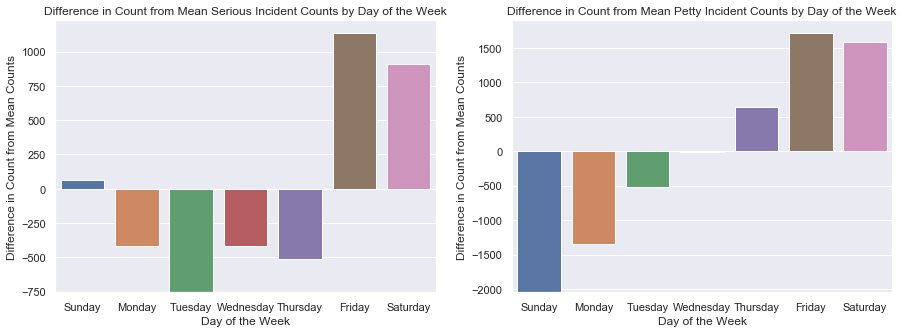

In [257]:
incident_counts_by_weekday = incident_count_table('weekday')
incident_counts_by_weekday['diff_from_mean_serious'] = incident_counts_by_weekday['serious'].apply(
    lambda x: x - np.mean(incident_counts_by_weekday['serious']))
incident_counts_by_weekday['diff_from_mean_petty'] = incident_counts_by_weekday['petty'].apply(
    lambda x: x - np.mean(incident_counts_by_weekday['petty']))

fig, (ax1, ax2) = plt.subplots(figsize=(15,5), ncols=2)
sns.barplot(x='weekday', y='diff_from_mean_serious', data=incident_counts_by_weekday,
            order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], ax=ax1)
plt.xlabel('Day of the Week')
sns.barplot(x='weekday', y='diff_from_mean_petty', data=incident_counts_by_weekday,
            order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], ax=ax2)
ax1.set_xlabel('Day of the Week')
ax1.set_ylabel('Difference in Count from Mean Counts')
ax1.set_title('Difference in Count from Mean Serious Incident Counts by Day of the Week', fontsize=12)
ax2.set_xlabel('Day of the Week')
ax2.set_ylabel('Difference in Count from Mean Counts')
ax2.set_title('Difference in Count from Mean Petty Incident Counts by Day of the Week', fontsize=12)
plt.show()

As expected, more incidents of both types occur more on Friday and Saturday than on any other day. This could be due to there being more people and cars out and about at the end of the week, which would most likely lead to more incidents occurring, accidental or not. Sunday is the least likely day for petty incidents to occur, which may be the case for the opposite reason; less people are out leading to less incidents.

I will now plot the distribution of incident counts by hour as a grouped bar chart.

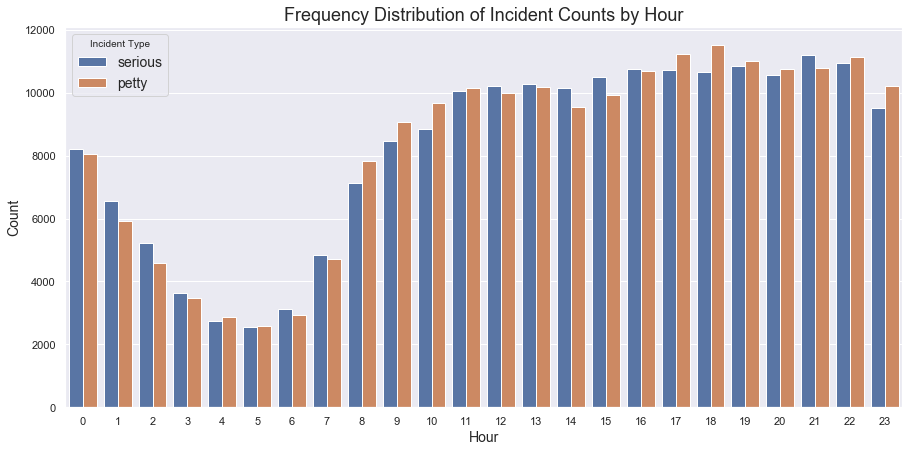

In [258]:
incident_counts_by_hour = incident_count_table('hour')
incident_counts_by_hour_melt = pd.melt(incident_counts_by_hour, id_vars='hour',
                                       var_name='incident_type', value_name='count')

fig, ax1 = plt.subplots(figsize=(15, 7))
sns.barplot(x='hour', y='count', hue='incident_type', data=incident_counts_by_hour_melt, ax=ax1)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Frequency Distribution of Incident Counts by Hour',fontsize=18)
plt.legend(title='Incident Type', fontsize=14)
plt.show()

Intuitively, the plot makes sense, as more crimes are likely to occur during the afternoon and nighttime than in the very early morning regardless if they are serious or petty. Serious crimes seem to be more likely to happen after midnight and in the afternoon than petty crimes, while petty crimes dominate most of the morning and late evening. 

I again plotted incident counts by month as a grouped bar chart to see its distribution.

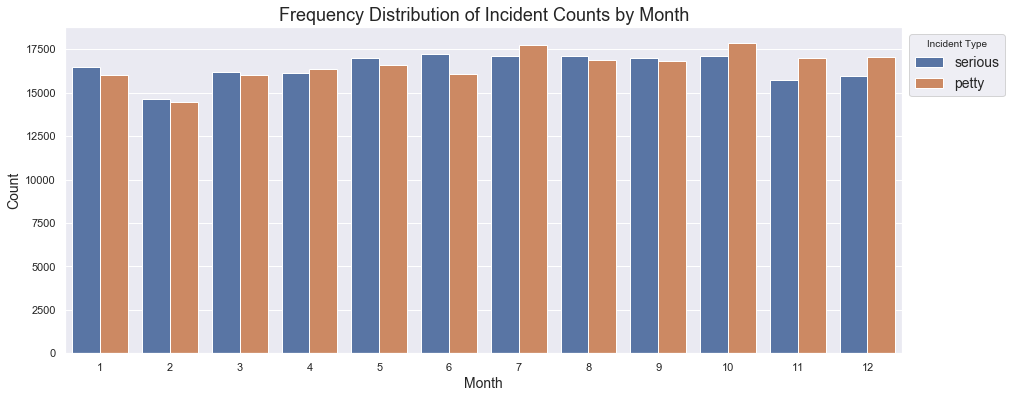

In [259]:
incident_counts_by_month = incident_count_table('month')
incident_counts_by_month_melt = pd.melt(incident_counts_by_month, id_vars='month', 
                                        var_name='incident_type', value_name='count')

fig, ax1 = plt.subplots(figsize=(15, 6))
sns.barplot(x='month', y='count', hue='incident_type', data=incident_counts_by_month_melt, ax=ax1)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Frequency Distribution of Incident Counts by Month',fontsize=18)
plt.legend(bbox_to_anchor=(1, 1), title='Incident Type', fontsize=14)
plt.show()

Some key insights: generally, more serious incidents occur in the first six months of the year, and more petty in the latter six months; The bars for February are much lower than the rest of the months, possibly due to it being the shortest month of the year.

### Examining Priority Variable
Police departments assign each incident a priority, which represents the urgency of the response to the incident. A priority of one is the highest importance and nine is the lowest. 

I would like to examine the counts of each incident type by priority to confirm my suspicions. I use my function incident_count_table() to do this. 

In [260]:
incident_counts_by_priority = incident_count_table('priority').fillna(0)
incident_counts_by_priority

,priority,serious,petty
0,1,62748.0,12299
1,2,105922.0,144903
2,3,25108.0,38551
3,4,509.0,612
4,5,3390.0,2304
5,6,114.0,258
6,7,0.0,1
7,8,0.0,1


As expected, there are no serious incidents with priorities of 7, 8, or 9. Furthermore, there is only one instance each of petty incidents with priorities of 7 or 8, and none with 9. This means that any incident with a priority of 7 or 8 is likely to be classified as petty. Because it is unlikely that actual serious crimes would be given a low priority by the police department, this may be a good assumption to make, although high valued priorities seem to be very rare both in this data and in the real world.

# Feature Selection

### Chi-Squared Tests for Independence
In order to determine if I should use the features 'district', 'weekday', 'hour', 'month', and 'priority' for classifying incident type, I will test if each variable is independent from incident type using a chi-squared test for independence. The null hypothesis of each test will be that the observed frequencies for each variable match the expected frequencies for the variable, and the alternate hypothesis will be that they do not match. 

For each variable, I have constructed a contingency table (this was done during the visualization of each variable above) using my function incident_count_table(). These tables will be fed into my user-defined function determine_feature_relevance(), which takes the table and a confidence level as arguments, and using functions for chi-squared tests from scipy, will return the p-value and result of the test. 

In [261]:
from scipy.stats import chi2_contingency, chi2

def determine_feature_relevance(table, prob):
    stat, p, dof, expected = chi2_contingency(table)
    critical = chi2.ppf(prob, dof)
    if abs(stat) >= critical:
        return (p, 'dependent (reject H0)')
    else:
        return (p, 'independent (fail to reject H0)')
    
incident_count_tables = (['district', incident_counts_by_district], ['weekday', incident_counts_by_weekday], 
                         ['hour', incident_counts_by_hour], ['month', incident_counts_by_month],
                         ['priority', incident_counts_by_priority])

for name, df in incident_count_tables:
    cont_table = df.iloc[:, [1,2]]
    p_val, result = determine_feature_relevance(cont_table, 0.995)
    print(name, 'and incident_type are', result, '---p-value =', p_val)

district and incident_type are dependent (reject H0) ---p-value = 0.0
weekday and incident_type are dependent (reject H0) ---p-value = 6.637728311214383e-27
hour and incident_type are dependent (reject H0) ---p-value = 3.570835766847955e-49
month and incident_type are dependent (reject H0) ---p-value = 1.3225625706804456e-30
priority and incident_type are dependent (reject H0) ---p-value = 0.0


Each test for all of the variables rejected the null hypothesis at 99.5% confidence, meaning we can include all variables as features in our classification with statistical significance. 

# Classification Models
There are several methods for classification problems involving categorical data, each with their own strengths and weaknesses. Here, I will apply the three basic versions of the models to get an idea of which is best for this dataset.

### Multinomial Naive Bayes Model
First, we try a Naive Bayes Classifier with Multinomial distributions of the categorical features. Naive Bayes is a fast and simple algorithm that works particularly well with categorical data, so it may be well-suited for this data. However, it assumes independence among features, which is not a realistic assumption given our data.

Below, I have prepared the data to be fed into the model by converting the variables to numeric categorical data and creating training and testing sets.

In [262]:
X = crime[['district', 'weekday', 'hour', 'month', 'priority']]
for i in range(X.shape[1]):
    X.iloc[:, i] = X.iloc[:, i].astype('category')
X['weekday'] = X['weekday'].cat.codes
y = crime['incident_type'].astype('category')

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now, I implement a simple 10-fold cross-validated Multinomial Bayes Model using scikit-learn.

In [263]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb_cv_results = cross_val_score(mnb, X_train, y_train, cv=10)
print(np.mean(mnb_cv_results))

0.5799745483578105


The result is a 58% accuracy score. Let's see if I can improve this score with other models.

### Logistic Regression
The Logistic Regression model is another probability based model for binary classification. Using the logistic (or sigmoid) function, a linear decision boundary is produced to classify data. 

Logistic regression for scikit-learn requires categorical feautures to be represented as dummy variables, so I convert all of the data using OneHotEncoder.

In [264]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train)
X_train_one_hot = enc.transform(X_train)
X_test_one_hot = enc.transform(X_test)

In [265]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs')
lr_cv_results = cross_val_score(lr, X_train_one_hot, y_train, cv=10)
print(np.mean(lr_cv_results))

0.6325998182386375


The result of the 10-fold cross-validated Logistic Regression model is a 63.26% accuracy score. This model performs better than the Naive Bayes classifier, but is still relatively low. 

### Random Forest Classifier
The Random Forest Classifier is an ensemble method combining multiple decision trees to perform classification. Although more computationally intense than the previous two models, it is a high performing classifier that can be protected from errors in the individual decision trees. 

Again, we use scikit-learn to implement the model with the dummy variable data.

In [266]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=25,max_depth=10)
rf_cv_results = cross_val_score(rf, X_train, y_train, cv=10)
print(np.mean(rf_cv_results))

0.6387943678424702


The 10-fold cross-validated model performs about 0.5% higher than the logistic regression model.

# Conclusion
Logistic regression and random forests worked best with our data, but they were still not able to accurately predict incident type from the dataset. Because the features I am working with are only of three general categories (time, location, and priority), more diversified data with less correlation with each other may highly improve the models. In the future, I hope to be able to collect more numerical data for each incident, such as age of perpetrator, number of involved parties, and number of responding officers to have more features to work with that can more accurately classify the type of incident.